In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, accuracy_score, precision_score

C:\Anaconda3\envs\py35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
col_names = ['Damage','Ductility','Creep_Rate','Zeta_P', 'A', 'S_y', 
'Alpha', 'C_f', 'Sigma_B', 'Sigma_SU', 'Sigma_RT', 'T_SU', 'T_RT', 'T_SO', 'Sigma_SO']

MCS_Res_Base = pd.read_csv('MCS_10000_Tube_2_D_LHC.csv', 
                           index_col = False, names = col_names)
MCS_Res_Target = pd.read_csv('MCS_100000_Tube_2_D_LHC.csv', 
                             index_col = False, names = col_names)

# MCS_Res_Base = pd.read_csv('MCS_10000_Tube_29_D_LHC.csv', 
#                            index_col = False, names = col_names)
# MCS_Res_Target = pd.read_csv('MCS_100000_Tube_29_D_LHC.csv', 
#                              index_col = False, names = col_names)


Failure_Limit = 0.5 # When modelling creep-fatigue damage, a value >= Failure_Limit implies failure (or more specifically the formation of a shallow crack)

# Setting what features to include 
features = ['Ductility','Creep_Rate', 'A', 'S_y', 'Alpha', 'C_f']
#features = ['Ductility','Creep_Rate']

# Training data
Nb = len(MCS_Res_Base['Damage']) # Number of bins in the latin-hypercube
X_train = MCS_Res_Base[features]/Nb
y_train = (MCS_Res_Base['Damage'] >= Failure_Limit)
d_train = MCS_Res_Base['Damage']

# Testing data
Nb = len(MCS_Res_Target['Damage']) # Number of bins in the latin-hypercube
X_test = MCS_Res_Target[features]/Nb
y_test = (MCS_Res_Target['Damage'] >= Failure_Limit)
d_test = MCS_Res_Target['Damage'] 



# Conducting some exploratory data analysis to check that the chosen features can be useful for predicting large damages

In [3]:
# Checking that both the training and testing datasets give similar probabilities of failure
print('Percentage of failures in training set = ' + str(100*sum(y_train)/len(y_train)) + '%')
print('Percentage of failures in testing set = ' + str(100*sum(y_test)/len(y_test)) + '%')

Percentage of failures in training set = 2.31%
Percentage of failures in testing set = 2.376%


C:\Anaconda3\envs\py35\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


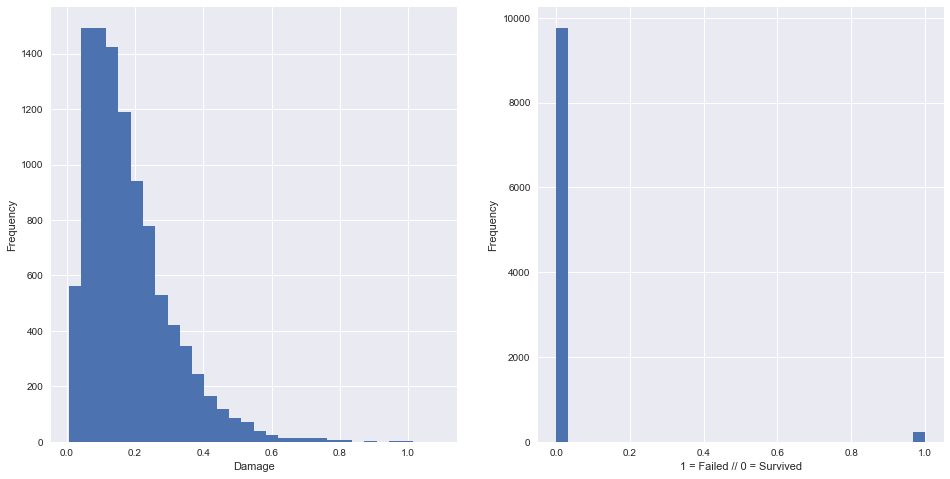

In [4]:
# Histogram of the values of damage in the training data
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1)
MCS_Res_Base['Damage'].hist(bins = 30)
plt.xlabel("Damage")
plt.ylabel("Frequency")

# Histogram of the number of failures (as defined by 'Failure_Limit') in the training data 
ax = fig.add_subplot(1,2,2)
y_train.hist(bins = 30)
plt.xlabel("1 = Failed // 0 = Survived")
plt.ylabel("Frequency")
fig.show()

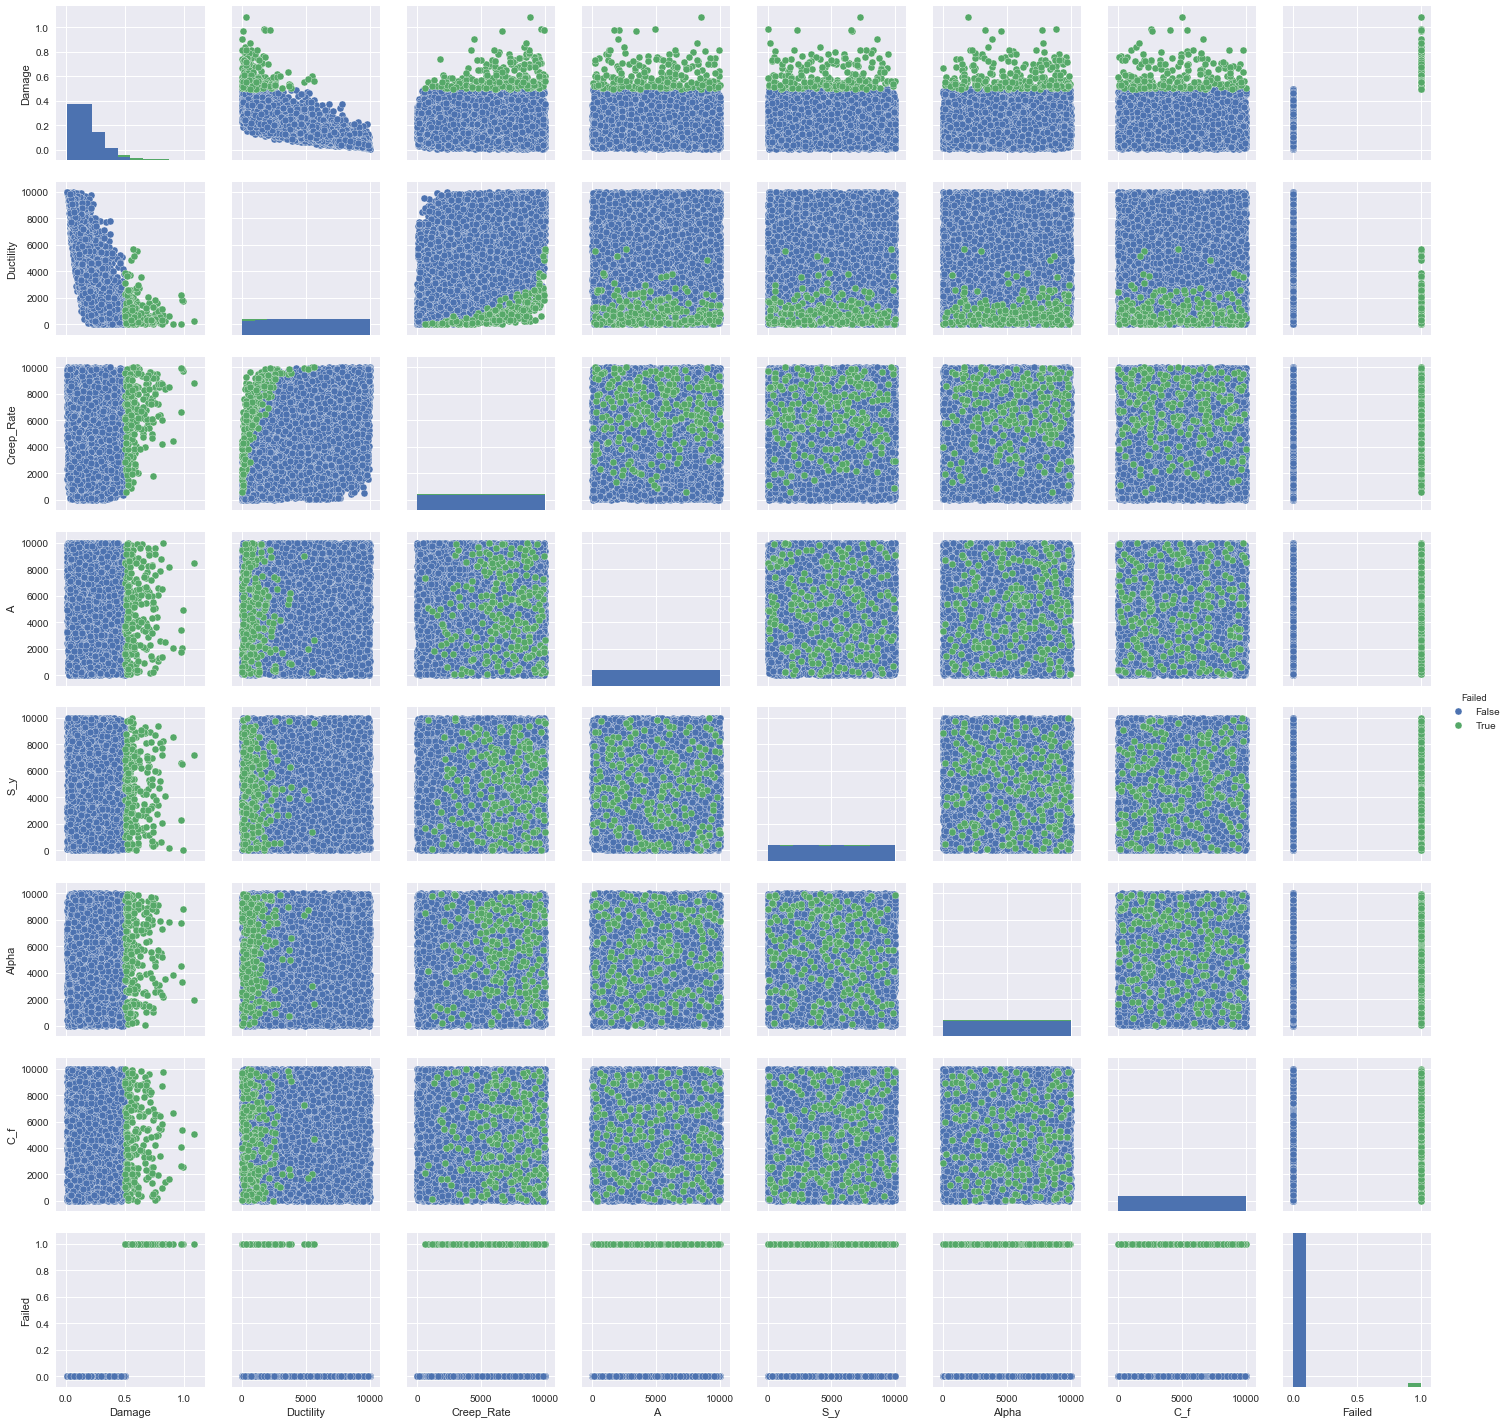

In [5]:
# Pairplots looking at the training dataset
MCS_Res_Base['Failed'] = y_train
sns.pairplot(MCS_Res_Base[['Damage','Ductility','Creep_Rate', 'A', 'S_y', 'Alpha', 'C_f', 'Failed']], hue = 'Failed')

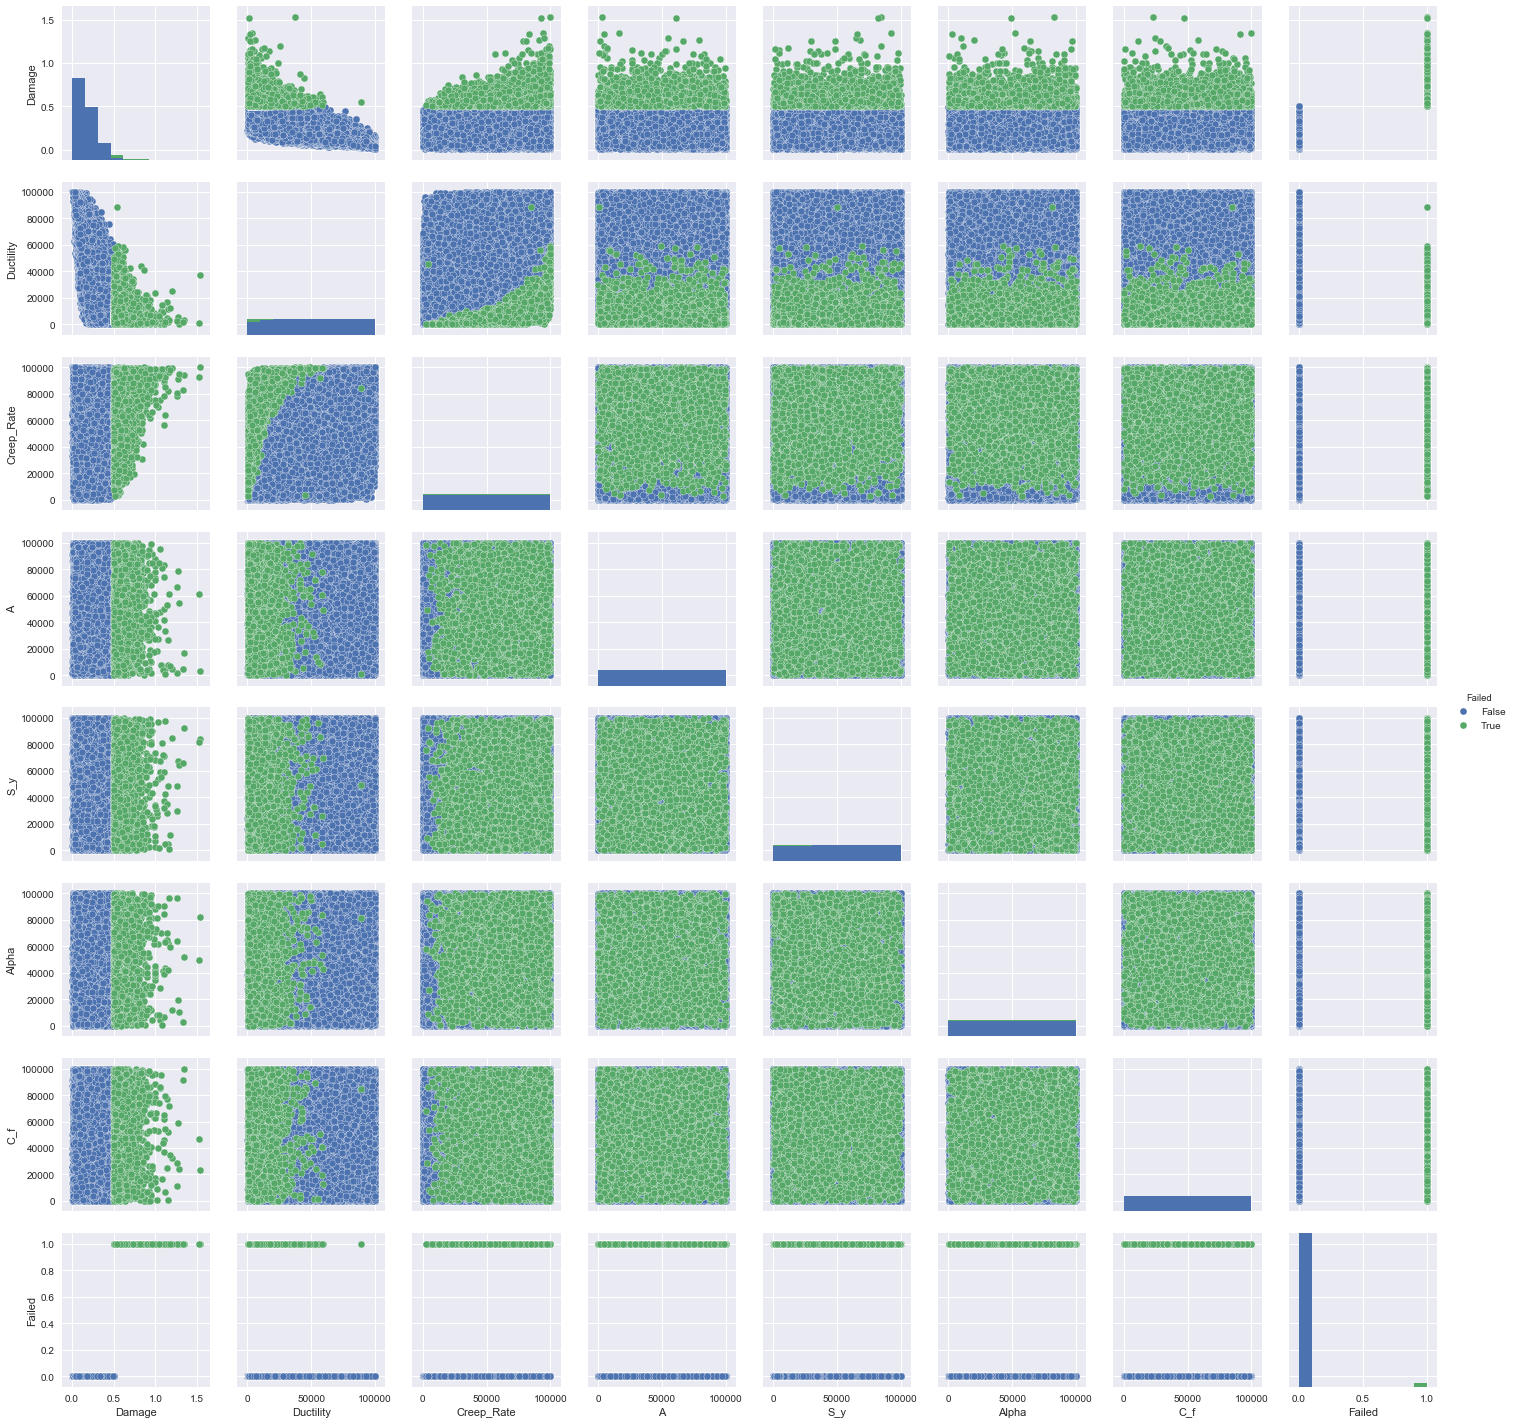

In [6]:
# Pairplots looking at the testing dataset
MCS_Res_Target['Failed'] = y_test
sns.pairplot(MCS_Res_Target[['Damage','Ductility','Creep_Rate', 'A', 'S_y', 'Alpha', 'C_f', 'Failed']], hue = 'Failed')

# Note:

For the above pair plots it appears that only two parameters (Ductility and Creep_Rate) have a marked effect on damage, which is consistent with sensitivity analysis results that I produced for my PhD project. High damages correlate with low Ductility and with high Creep_Rate. Moving forward, these two parameters will be the only two features which I will use to conduct classifications.

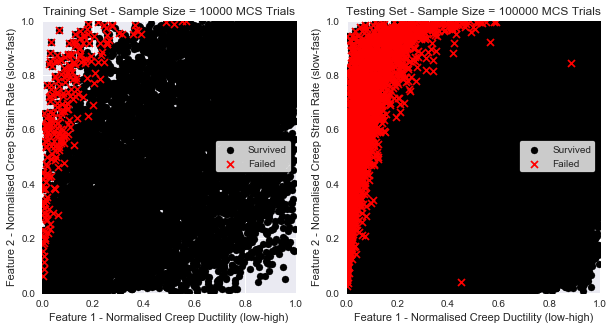

In [7]:
# Plotting the training set (the two main features and failures)

fig = plt.figure(figsize= (10,5))
fig.add_subplot(1,2,1)
plt.scatter(X_train['Ductility'], X_train['Creep_Rate'], color = 'k', label ='Survived')
plt.scatter(X_train['Ductility'][y_train], X_train['Creep_Rate'][y_train], color = 'r', marker = 'x', label = 'Failed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Training Set - Sample Size = ' + str(len(y_train)) + ' MCS Trials')
plt.xlabel('Feature 1 - Normalised Creep Ductility (low-high)')
plt.ylabel('Feature 2 - Normalised Creep Strain Rate (slow-fast)')
plt.legend(loc = 'center right', frameon = True, facecolor = 'w')

# Plotting the testing set (the two main features and failures)

fig.add_subplot(1,2,2)
plt.scatter(X_test['Ductility'], X_test['Creep_Rate'], color = 'k', label ='Survived')
plt.scatter(X_test['Ductility'][y_test], X_test['Creep_Rate'][y_test], color = 'r', marker = 'x', label = 'Failed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Testing Set - Sample Size = ' + str(len(y_test)) + ' MCS Trials')
plt.xlabel('Feature 1 - Normalised Creep Ductility (low-high)')
plt.ylabel('Feature 2 - Normalised Creep Strain Rate (slow-fast)')
plt.legend(loc = 'center right', frameon = True, facecolor = 'w')
plt.show()

# Note:

Based on the chosen features (Ductility & Creep_Rate) see if the common ML classification algorithems can help in detecting failed trials in the testing data set. 

In [8]:
# Trying a random forest algorithem 

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000)


model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
pred_prob = model.predict_proba(X_test)


# Using a different probability threshold for classification rather than the defult 0.5 value
y_pred = (pred_prob[:,0] < 0.95)

No_MCT = (sum(y_pred)/len(y_pred))*100

# calculate the accuracy score
conf_mat = confusion_matrix(y_test, y_pred)


print("F1-Score = " + str(f1_score(y_test, y_pred)*100))
print('-------------------')
print("Precision-Score = " + str(precision_score(y_test, y_pred)* 100))
print('-------------------')
print("Recall-Score = " + str(recall_score(y_test, y_pred)* 100))
print('-------------------')
print('Confusion Matrix for ' + "Random Forest" + ':')
print(conf_mat)
print('-------------------')
print('Percentage Number of MCS trials Needed using ' + "Random Forest" + ' = ' + str(No_MCT) + ' %')
print('-------------------')


F1-Score = 51.60175155565799
-------------------
Precision-Score = 35.528403681370996
-------------------
Recall-Score = 94.23400673400674
-------------------
Confusion Matrix for Random Forest:
[[93561  4063]
 [  137  2239]]
-------------------
Percentage Number of MCS trials Needed using Random Forest = 6.3020000000000005 %
-------------------


# Note:

Now I want to try a number of ML classification algorithems to see if any of them achieves good classification performance. The required classifier would need to correctly classify most failures (negatives), but none of the above classification algorithms achieves that. Misclassifying survivals as failures could be tolerated, but misclassifying failures as survivals would jeopardise the results of the MCS. 

In [9]:
def run_model(model, alg_name, plot_index):
    # build the model on training data
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)


    ProbRange = np.arange(0.01,1,0.01)
    FPs = np.zeros(np.shape(ProbRange))
    TNs = np.zeros(np.shape(ProbRange))
    f1 = np.zeros(np.shape(ProbRange)) 
    P_Score = np.zeros(np.shape(ProbRange))
    TNR = np.zeros(np.shape(ProbRange))
    R_Score = np.zeros(np.shape(ProbRange)) 
    No_MCT = np.zeros(np.shape(ProbRange)) 


    for i,Threshold in enumerate(ProbRange):
        y_pred = (pred_prob[:,0] < Threshold)
        # calculate the accuracy score
        conf_mat = confusion_matrix(y_test, y_pred)
        FPs[i] = conf_mat[1,0]
        TNs[i] = conf_mat[1,1]
        f1[i] = f1_score(y_test, y_pred)* 100
        P_Score[i] = precision_score(y_test, y_pred)* 100
        R_Score[i] = recall_score(y_test, y_pred)* 100
        TNR[i] = (conf_mat[1,1]/(conf_mat[1,1] + conf_mat[1,0]))*100
        No_MCT[i] = sum(y_pred) # (sum(y_pred)/len(y_pred))*100
        
        
    fig = plt.figure(figsize=(15,6))
    fig.add_subplot(1,2,1)
    plt.scatter(ProbRange,P_Score,color = 'b',label = 'Precision')
    plt.scatter(ProbRange,R_Score,color = 'k',label = 'Recall')
    #plt.scatter(ProbRange,TNR,color = 'r', label = 'True Negative Rate')
    plt.scatter(ProbRange,f1,color = 'g', label = 'F1')
    plt.title(alg_name)
    plt.ylabel('Metrics in %')
    plt.xlabel('Threshold Probability')
    plt.legend(loc = 'best', frameon = True, facecolor = 'w')


    fig.add_subplot(1,2,2)
    plt.scatter(ProbRange,FPs,color = 'b',label = 'False Positives')
    plt.scatter(ProbRange,TNs,color = 'r',label = 'True Negatives')
    plt.scatter(ProbRange,No_MCT,marker= 'x', color = 'k',label = 'Required MCS trials out of ' + str(len(y_test)))
    plt.legend(loc = 'best', frameon = True, facecolor = 'w')
    plt.title(alg_name)
    plt.ylabel('Number of MCS trails')
    plt.xlabel('Threshold Probability')
    

In [10]:
def Compare_Classifiers(X_train, X_test, y_train, y_test):

    fig = plt.figure(figsize=(15,20))

    # ---- Decision Tree -----------
    from sklearn import tree

    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
    run_model(model, "Decision Tree", 1)

    # ----- Random Forest ---------------
    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(n_estimators=1000)
    run_model(model, "Random Forest", 2)

    # ----- xgboost ------------
    # install xgboost
    # 'pip install xgboost' or https://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform/39811079#39811079

    from xgboost import XGBClassifier

    model = XGBClassifier()
    run_model(model, "XGBoost", 3)


    # -------- Nearest Neighbors ----------
    from sklearn import neighbors
    model = neighbors.KNeighborsClassifier(n_neighbors=50)
    run_model(model, "Nearest Neighbors Classifier", 4)


    # --------- Gaussian Naive Bayes ---------
    from sklearn.naive_bayes import GaussianNB

    model = GaussianNB()
    run_model(model, "Gaussian Naive Bayes", 5)

    # ----------- Neural network - Multi-layer Perceptron  ------------
    from sklearn.neural_network import MLPClassifier

    model = MLPClassifier()
    run_model(model, " MLP Neural network ", 6)


C:\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\py35\lib\site-packages\sklearn

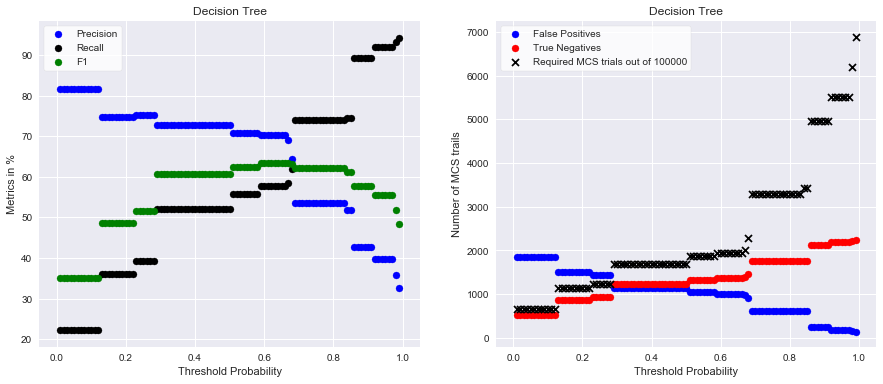

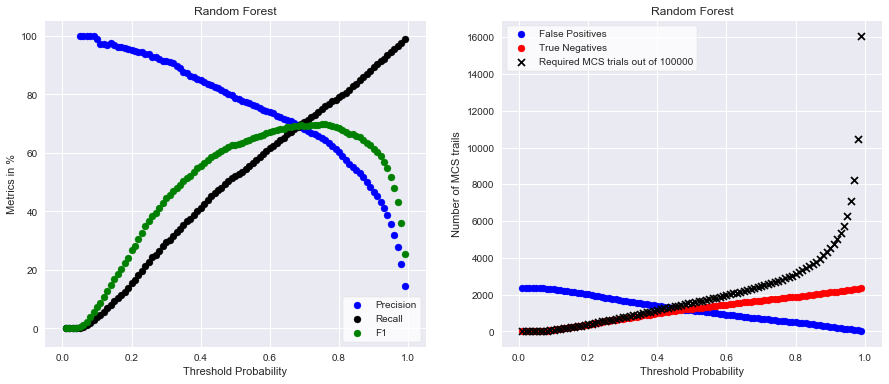

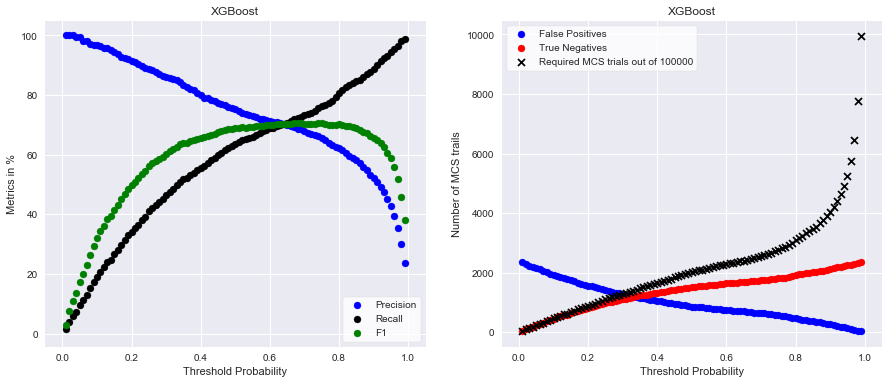

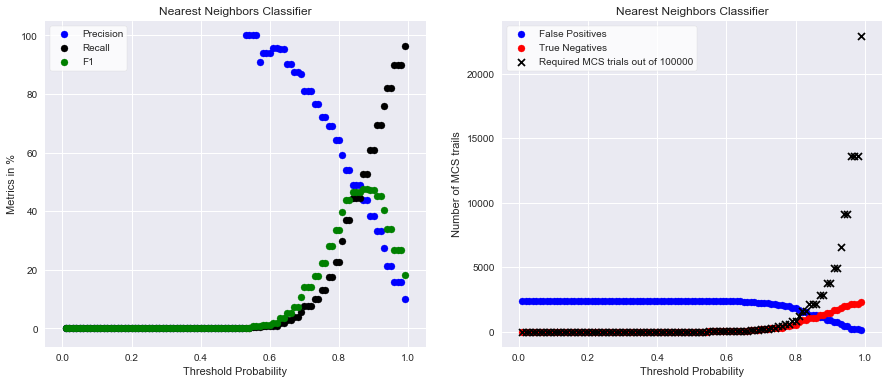

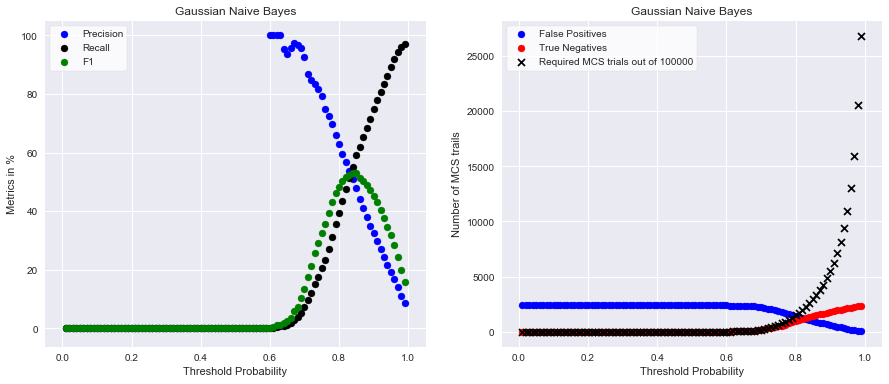

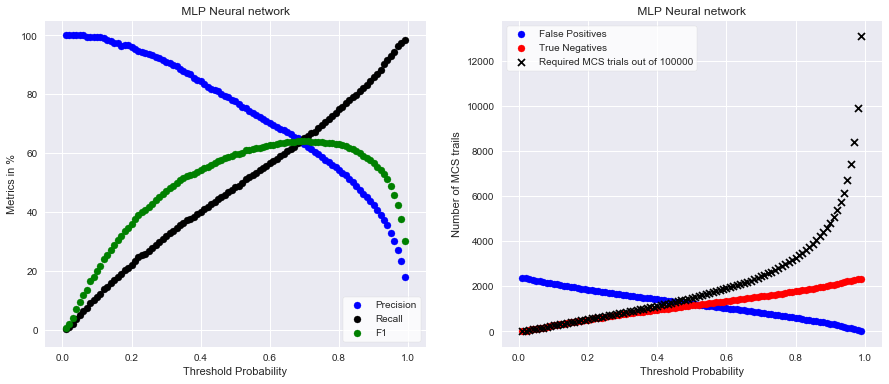

In [11]:
# Run the comparison between classifers
Compare_Classifiers(X_train, X_test, y_train, y_test)

# Performance Metrics: 

The performance of the algorithems is reflected by the recall, precision and F1 scores. The best algorithm would have optimal recall for the smallest number of required MCS trials, and the least number of false positives. At threshold probabilities that are large enough, most of the the above algorithms produce decent recall scores. The ones that did best seem to be the Random Forest, the XGBoost and the MLP Neural Network.  

# Feature Engineering

The follwing is an investiagation of whether some different measures (related to the two features above) can be used instead for further imporving the classification performance. 

# Key insights:

The distance between any given trail/point in the state-space and the centre of the state-space (0.5,0.5) gives a good indication of how likely the subject point is likely to be a failed point. 

The orientation also seems to be important. A point that's close to the center point but to the left is less likely to be a failure than one that's to the right.

The following are simple exploratory analyses to investigate the validity of these two prospective new features. 


In [12]:
# Retriving the locations of the failed trials
Failed_Trials = MCS_Res_Base[features][MCS_Res_Base['Damage']>=Failure_Limit]

x_ind = np.array(Failed_Trials['Ductility']) # the -1 is for zero indexing
y_ind = np.array(Failed_Trials['Creep_Rate']) # the len(MCS_Res_Base['Creep_Rate']) is to account for the flipped meshgrid AND zero indexing


In [13]:

# A function that takes a dy and a dx and converts them into an angle between 0 and 360 degrees

def Correct_Angle(dy,dx):
    
    radians = np.arctan(np.abs(dy/dx))

    degrees = radians*180/np.pi

    if (dy > 0) & (dx > 0):
        degrees = degrees
    elif (dy > 0) & (dx < 0):
        degrees = 180 - degrees
    elif (dy < 0) & (dx < 0):
        degrees = 180 + degrees
    elif (dy < 0) & (dx > 0):
        degrees = 360 - degrees          
        
    return degrees


In [14]:
def HistogramProbabilities(Data,R1,R2,dR):
    
    freq, bin_edges  = np.histogram(Data, bins = round(len(Data)**0.5), normed = True)
    
    Range = np.arange(R1,R2,dR)

    Prob =  [freq[(V >=(bin_edges[0:(int(len(bin_edges))-1)])) &  (V <= (bin_edges[1:]))] 
             if 
             sum((V >=(bin_edges[0:(int(len(bin_edges))-1)])) &  (V <= (bin_edges[1:]))) 
             else 
             0.0000000001 
             for V in Range]  

#     fig = plt.figure()
#     fig.add_subplot(1,2,1)
#     plt.hist(Data, bins = round(len(Data)**0.5), normed = True)
#     fig.add_subplot(1,2,2)
#     plt.scatter(Range,Prob)
    
    return Prob, Range

In [15]:
# Calculating the distances and angles of all points relative to the mid-point in the state-spece 

Global_Angles = MCS_Res_Base[['Ductility','Creep_Rate']].apply(
    lambda x: Correct_Angle(x[1] - (len(MCS_Res_Base)/2),x[0]-(len(MCS_Res_Base)/2)), axis=1)

Global_Dists = MCS_Res_Base[['Ductility','Creep_Rate']].apply(
    lambda x: ((x[1] - (len(MCS_Res_Base)/2))**2  + (x[0] - (len(MCS_Res_Base)/2))**2)**0.5, axis=1)


C:\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


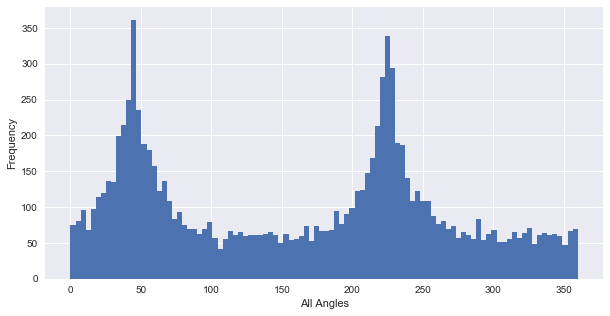

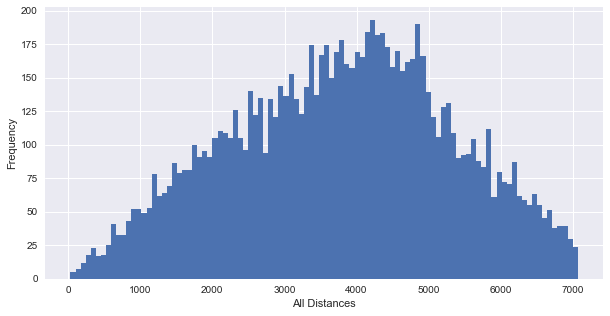

In [16]:
# Quick check that the distances and angles calculation gives the correct angwers
plt.figure(figsize=(10,5))
plt.hist(Global_Angles, bins = int(len(Global_Angles)**0.5))
plt.xlabel('All Angles')
plt.ylabel('Frequency')

plt.figure(figsize=(10,5))
plt.hist(Global_Dists, bins = int(len(Global_Angles)**0.5))
plt.xlabel('All Distances')
plt.ylabel('Frequency')

# Note:

Explanation for the bimodal histogram is that Ductility and Creep-Rate are correlated parameters and therefore the distribution of points/trials in the state space is not homogenous. 
 

(0, 7500)

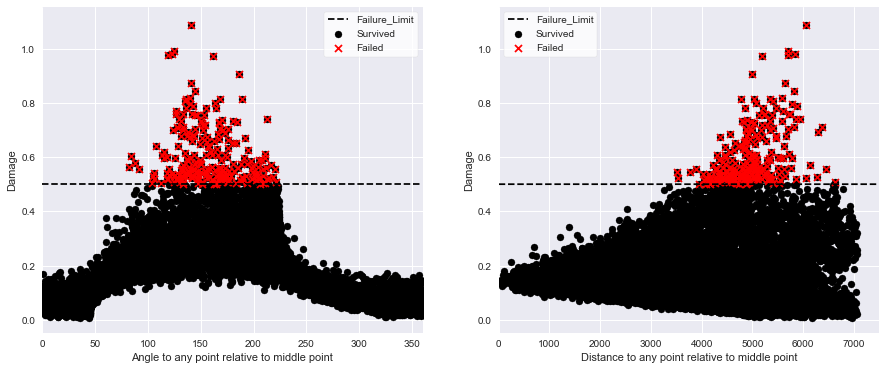

In [17]:
# Checking if angles/distances correlate with failures

fig = plt.figure(figsize=(15,6))

fig.add_subplot(1,2,1)
plt.plot(np.arange(0,360,1),np.ones((360,1))*Failure_Limit,'--k', label = 'Failure_Limit')
plt.scatter(Global_Angles,MCS_Res_Base['Damage'],color = 'k')
plt.scatter(Global_Angles[MCS_Res_Base['Damage']>=Failure_Limit],
            MCS_Res_Base['Damage'][MCS_Res_Base['Damage']>=Failure_Limit],
           color = 'r', marker = 'x')



plt.xlabel('Angle to any point relative to middle point')
plt.ylabel('Damage')
plt.legend(['Failure_Limit', 'Survived', 'Failed'],loc = 'best', frameon = True, facecolor = 'w')
plt.xlim(0,360)

fig.add_subplot(1,2,2)
plt.plot(np.arange(0,7500,1),np.ones((7500,1))*Failure_Limit,'--k', label = 'Failure_Limit')           
plt.scatter(Global_Dists,MCS_Res_Base['Damage'],color = 'k')
plt.scatter(Global_Dists[MCS_Res_Base['Damage']>=Failure_Limit],
            MCS_Res_Base['Damage'][MCS_Res_Base['Damage']>=Failure_Limit],
            color = 'r', marker = 'x')

plt.xlabel('Distance to any point relative to middle point')
plt.ylabel('Damage')
plt.legend(['Failure_Limit', 'Survived', 'Failed'],loc = 'best', frameon = True, facecolor = 'w')
plt.xlim(0,7500)
           
            

# Note:

When viewing from the centre point there are some directions/angles that can increase damage (~90-220 degrees). 

In [18]:
# Examining the conditional probabilities

FailedAngles = Global_Angles[MCS_Res_Base['Damage']>=Failure_Limit]
FailedAngles = FailedAngles[~np.isnan(FailedAngles)]

FailedDists = Global_Dists[MCS_Res_Base['Damage']>=Failure_Limit]
FailedDists = FailedDists[~np.isnan(FailedDists)]

GlobalFailedAngles = FailedAngles
GlobalFailedDists = FailedDists

In [19]:
# Sample the histograms for the entire range of possible values of each of the new features
GFA_Probs, GFA_Range = HistogramProbabilities(GlobalFailedAngles,0,361,1)
GFD_Probs, GFD_Range = HistogramProbabilities(GlobalFailedDists,0,14200,1)

# Checking the size of the probability matricies for the new features  
print(np.shape(GFD_Probs))
print(np.shape(GFA_Probs))

(14200,)
(361,)


# Notes:

So far I came up with two new features to classify trials:

1. The absolute distance between a given trail/point anywhere within the state-space and the centre point of the state-space.
2. The origentation (or angle) between a given trail/point anywhere within the state-space and the centre point of the state-space. This is measured in degrees (rather than radians) and with 0 degrees being the Eastward direction, and measured poitive anti-clockwise

Now I need to calculate the new features for the testing set. The following code is to calculate the distances between all points in the state-space w.r.t the centre point (0.5,0.5)

C:\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


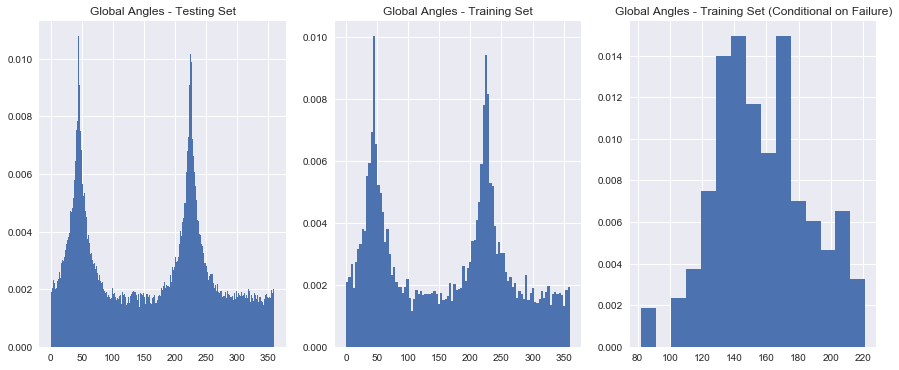

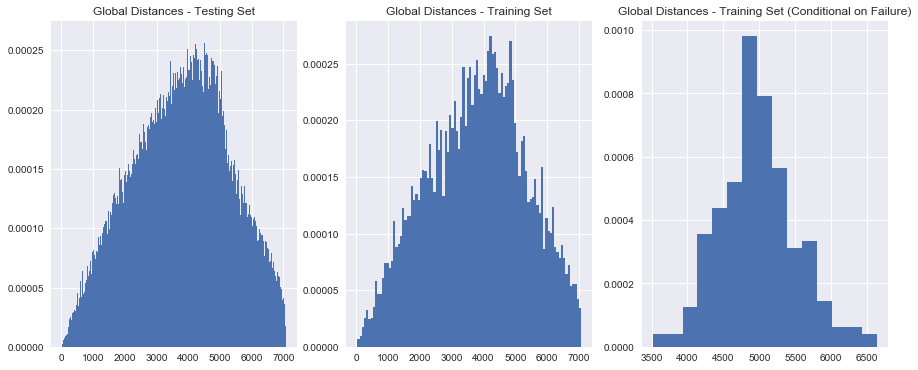

In [20]:
# Needed for refactor the Ductility and Creep_Rate factors for consistency between the training and testing sets:
ScaleFactor = len(MCS_Res_Target)/len(MCS_Res_Base) 

Adjusted_Testing_Set = MCS_Res_Target.apply(lambda x: x[1:]/ScaleFactor, axis = 1)


Test_GA = Adjusted_Testing_Set[['Ductility','Creep_Rate']].apply(
    lambda x: Correct_Angle(x[1] - (len(Adjusted_Testing_Set)/ScaleFactor/2),x[0]-(len(Adjusted_Testing_Set)/ScaleFactor/2)), axis=1)

Test_GD = Adjusted_Testing_Set[['Ductility','Creep_Rate']].apply(
    lambda x: ((x[1] - (len(Adjusted_Testing_Set)/ScaleFactor/2))**2  + (x[0] - (len(Adjusted_Testing_Set)/ScaleFactor/2))**2)**0.5, axis=1)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1) 
ax.hist(Test_GA, bins = round(len(Test_GA)**0.5), normed = True)
ax.set_title('Global Angles - Testing Set')
ax = fig.add_subplot(1,3,2) 
ax.hist(Global_Angles, bins = round(len(Global_Angles)**0.5), normed = True)
ax.set_title('Global Angles - Training Set')
ax = fig.add_subplot(1,3,3) 
ax.hist(GlobalFailedAngles, bins = round(len(GlobalFailedAngles)**0.5), normed = True)
ax.set_title('Global Angles - Training Set (Conditional on Failure)')

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1) 
ax.hist(Test_GD, bins = round(len(Test_GD)**0.5), normed = True)
ax.set_title('Global Distances - Testing Set')
ax = fig.add_subplot(1,3,2) 
ax.hist(Global_Dists, bins = round(len(Global_Dists)**0.5), normed = True)
ax.set_title('Global Distances - Training Set')
ax = fig.add_subplot(1,3,3) 
ax.hist(GlobalFailedDists, bins = round(len(GlobalFailedDists)**0.5), normed = True)
ax.set_title('Global Distances - Training Set (Conditional on Failure)')

In [21]:
# Convert the features in the testing set into integer number so they can be used as indicies

Test_GFA_Prob = [float(GFA_Probs[Test_GA.astype(int)[i]]) for i in range(0,len(Test_GA))]
Test_GFD_Prob = [float(GFD_Probs[Test_GD.astype(int)[i]]) for i in range(0,len(Test_GD))]

Test_GFD_Prob = np.array(Test_GFD_Prob)
Test_GFA_Prob = np.array(Test_GFA_Prob)

# Checking the shapes of these probability arrays
print(np.shape(Test_GFD_Prob))
print(np.shape(Test_GFA_Prob))


(100000,)
(100000,)


In [22]:
# Calculating the denominator probability term in Bayes' rule

All_Probs_GD,R = HistogramProbabilities(Test_GD,0,14200,1)
All_Probs_GA,R = HistogramProbabilities(Test_GA,0,361,1)

Test_GD_Prob = [float(All_Probs_GD[Test_GD[i].astype(int)]) for i in range(0,len(Test_GD))] 
Test_GA_Prob = [float(All_Probs_GA[Test_GA[i].astype(int)]) for i in range(0,len(Test_GA))]
    
Test_GD_Prob = np.array(Test_GD_Prob)
Test_GA_Prob = np.array(Test_GA_Prob)

# Checking the shapes of these probability arrays
print(np.shape(Test_GD_Prob))
print(np.shape(Test_GA_Prob))
    

(100000,)
(100000,)


In [23]:
# Calculating the probabilisties based on which the trials in the testing set will be classified

Prob_GD = np.divide(Test_GFD_Prob,Test_GD_Prob)

Prob_GA = np.divide(Test_GFA_Prob,Test_GA_Prob)

Prob_Failure = ((MCS_Res_Target['Damage'] >= Failure_Limit)/len(MCS_Res_Target['Damage']))

Pred_Prob = (Prob_GD * Prob_GA) * Prob_Failure # Bayes' rule


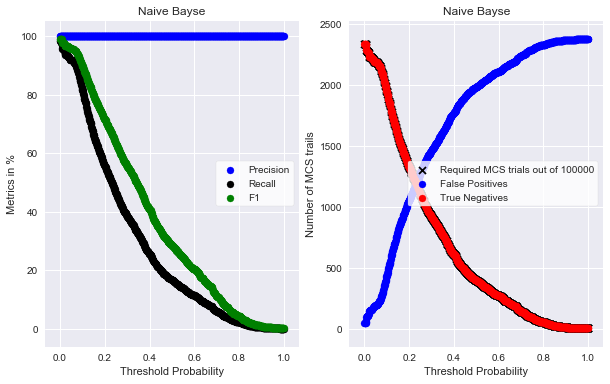

In [29]:
# Checking the performance of the Naive Bayes classifer for a range of threshold probabilities

ProbRange = np.arange(0.0001,1,0.001)

f1 = np.zeros(np.shape(ProbRange))
FPs = np.zeros(np.shape(ProbRange))
TNs = np.zeros(np.shape(ProbRange))
P_Score = np.zeros(np.shape(ProbRange))
R_Score = np.zeros(np.shape(ProbRange))
TNR = np.zeros(np.shape(ProbRange))
No_MCT = np.zeros(np.shape(ProbRange)) 

New_Failure_Limit = Failure_Limit

y_test_1 = MCS_Res_Target['Damage']>= New_Failure_Limit

for i,p in enumerate(ProbRange):
    y_pred = (Pred_Prob >= (np.max(Pred_Prob)*p))
    No_MCT[i] = sum(y_pred) #(sum(y_pred)/len(y_pred))*100
    conf_mat = confusion_matrix(y_test_1, y_pred)
    FPs[i] = conf_mat[1,0]
    TNs[i] = conf_mat[1,1]
    f1[i] = f1_score(y_test, y_pred)* 100
    P_Score[i] = precision_score(y_test, y_pred)* 100
    R_Score[i] = recall_score(y_test, y_pred)* 100
    TNR[i] = (conf_mat[1,1]/(conf_mat[1,1] + conf_mat[1,0]))*100

fig = plt.figure(figsize=(10,6))
fig.add_subplot(1,2,1)
plt.scatter(ProbRange,P_Score,color = 'b',label = 'Precision')
plt.scatter(ProbRange,R_Score,color = 'k',label = 'Recall')
#plt.scatter(ProbRange,TNR,color = 'r', label = 'True Negative Rate')
plt.scatter(ProbRange,f1,color = 'g', label = 'F1')
plt.title('Naive Bayse')
plt.ylabel('Metrics in %')
plt.xlabel('Threshold Probability')
plt.legend(loc = 'center right', frameon = True, facecolor = 'w')


fig.add_subplot(1,2,2)
plt.scatter(ProbRange,No_MCT,marker= 'x', color = 'k',label = 'Required MCS trials out of ' + str(len(y_test_1)))
plt.scatter(ProbRange,FPs,color = 'b',label = 'False Positives')
plt.scatter(ProbRange,TNs,color = 'r',label = 'True Negatives')
plt.legend(loc = 'center right', frameon = True, facecolor = 'w')
plt.title('Naive Bayse')
plt.ylabel('Number of MCS trails')
plt.xlabel('Threshold Probability')

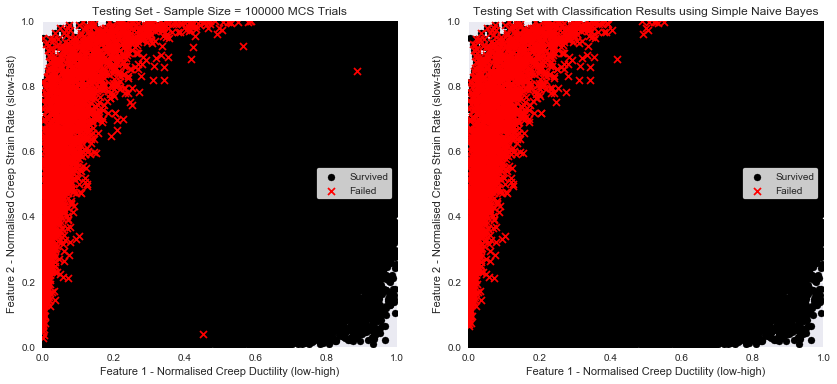

F1-Score = 99.10828025477709
-------------------
Precision-Score = 100.0
-------------------
Recall-Score = 98.23232323232324
-------------------
Confusion Matrix for Simple Naive Bayes:
[[97624     0]
 [   42  2334]]
-------------------
Percentage Number of MCS Trials Needed using Simple Naive Bayes = 2.334 %
-------------------


In [30]:
# Plotting the testing set (the two main features and failures)

P = min(ProbRange)

Nb = len(MCS_Res_Target['Ductility'])

fig = plt.figure(figsize= (14,6))
fig.add_subplot(1,2,1)
plt.scatter(MCS_Res_Target['Ductility']/Nb , MCS_Res_Target['Creep_Rate']/Nb , color = 'k', label ='Survived')
plt.scatter(MCS_Res_Target['Ductility'][y_test]/Nb, 
            MCS_Res_Target['Creep_Rate'][y_test]/Nb, 
            color = 'r', marker = 'x', label = 'Failed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Testing Set - Sample Size = ' + str(len(y_test)) + ' MCS Trials')
plt.xlabel('Feature 1 - Normalised Creep Ductility (low-high)')
plt.ylabel('Feature 2 - Normalised Creep Strain Rate (slow-fast)')
plt.legend(loc = 'center right', frameon = True, facecolor = 'w')

# Plotting the testing set (the two main features and failures)

fig.add_subplot(1,2,2)
plt.scatter(MCS_Res_Target['Ductility']/Nb , MCS_Res_Target['Creep_Rate']/Nb , color = 'k', label ='Survived')
plt.scatter(MCS_Res_Target['Ductility'][Pred_Prob >= (np.max(Pred_Prob)*P)]/Nb, 
            MCS_Res_Target['Creep_Rate'][Pred_Prob >= (np.max(Pred_Prob)*P)]/Nb, 
            color = 'r', marker = 'x', label = 'Failed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Testing Set with Classification Results using Simple Naive Bayes')
plt.xlabel('Feature 1 - Normalised Creep Ductility (low-high)')
plt.ylabel('Feature 2 - Normalised Creep Strain Rate (slow-fast)')
plt.legend(loc = 'center right', frameon = True, facecolor = 'w')
plt.show()


y_test_1 = MCS_Res_Target['Damage'] >= New_Failure_Limit
y_pred = (Pred_Prob >= (np.max(Pred_Prob)*P))


print("F1-Score = " + str(f1_score(y_test_1, y_pred)*100))
print('-------------------')
print("Precision-Score = " + str(precision_score(y_test_1, y_pred)* 100))
print('-------------------')
print("Recall-Score = " + str(recall_score(y_test_1, y_pred)* 100))
print('-------------------')
print('Confusion Matrix for ' + "Simple Naive Bayes" + ':')
print(confusion_matrix(y_test_1, y_pred))
print('-------------------')
print('Percentage Number of MCS Trials Needed using ' + "Simple Naive Bayes" + ' = ' + str(100*max(No_MCT)/Nb) + ' %')
print('-------------------')

In [26]:
X_train = pd.DataFrame()
X_train['Dists'] = Global_Dists
X_train['Angles'] = Global_Angles
X_train.head(10)
y_train = MCS_Res_Base['Damage'] >= Failure_Limit

X_test = pd.DataFrame()
X_test['Dists'] = Test_GD
X_test['Angles'] = Test_GA
X_test.head(10)
y_test = MCS_Res_Target['Damage'] >= Failure_Limit

from sklearn.preprocessing import StandardScaler

# Initialise the Scaler 
scaler = StandardScaler() 
# To scale data
scaler.fit(X_train)
X_train_s = scaler.transform(X_train, copy = True)
y_train = (MCS_Res_Base['Damage'] >= New_Failure_Limit)

# Initialise the Scaler 
scaler = StandardScaler() 
# To scale data
scaler.fit(X_test)
X_test_s = scaler.transform(X_test, copy = True)
y_test = (MCS_Res_Target['Damage'] >= New_Failure_Limit)

C:\Anaconda3\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


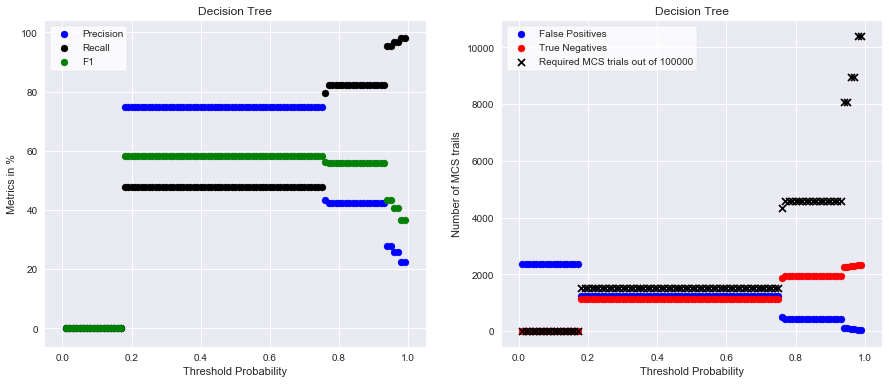

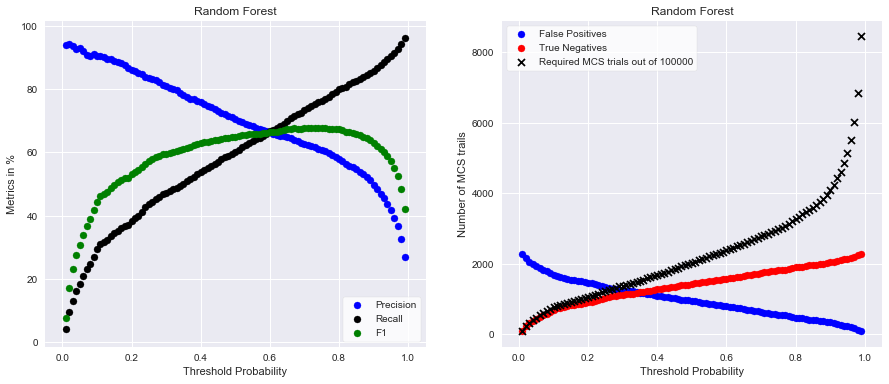

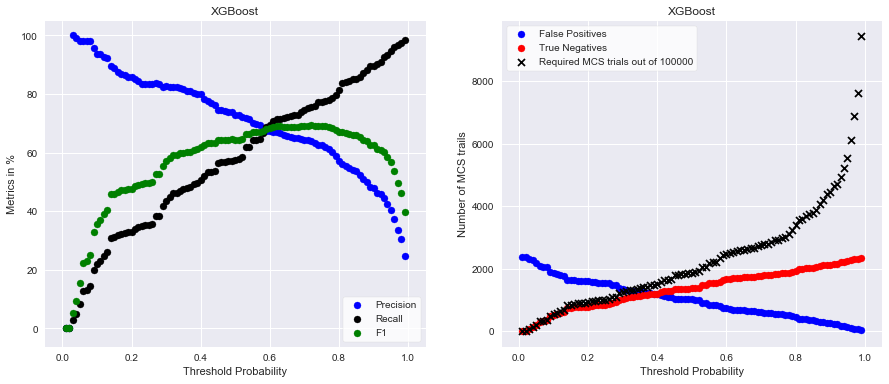

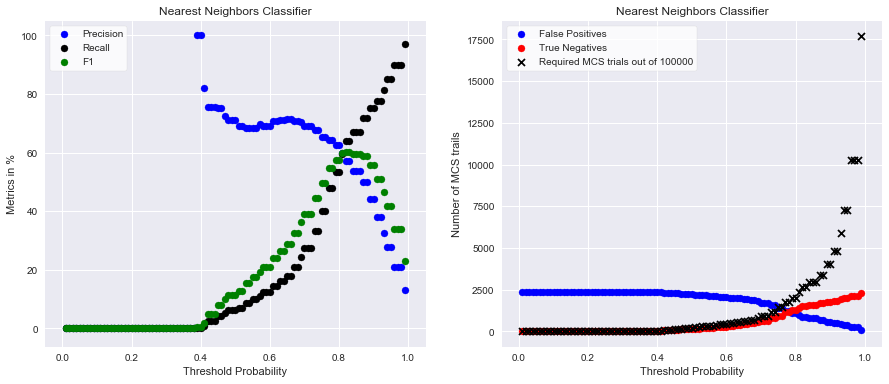

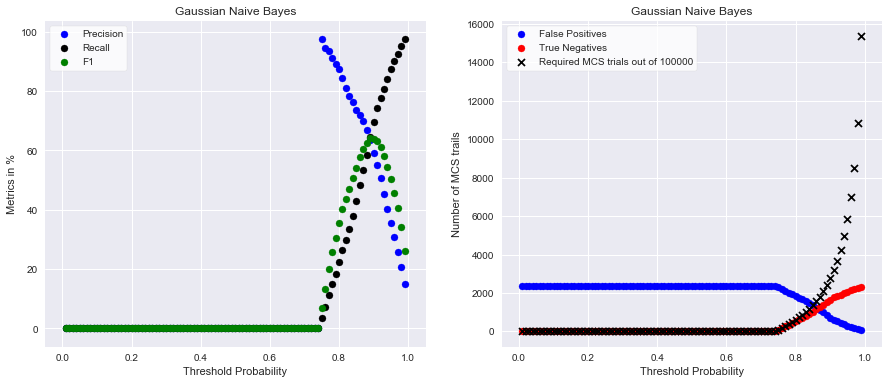

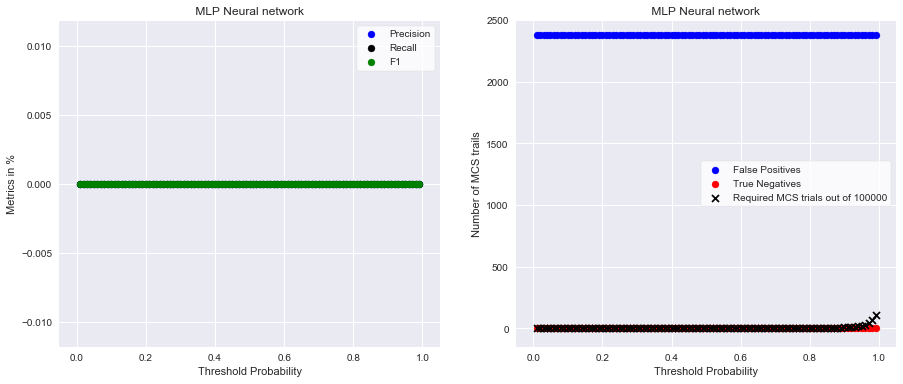

In [27]:
Compare_Classifiers(X_train_s, X_test_s, y_train, y_test)

# Conclusion

The ML classification algorithms performed well using the original features, but doing some feature engineering helped to reduce the number of MCS needed while maximising the recall-score. Better results can be achieved by fine-tuning the thrushold probabilies for each algorithm. In general, the desired conept was proven to be effective; classification can be used to target MCS trails in order to predict failure probabilities while monumentally reducing the number of calculations needed. 

